In [1]:
from torch_geometric.loader import DataLoader
import torch
# from torch_geometric.nn import GNNExplainer
from torch_geometric.explain import Explainer, GNNExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [18]:
import torch_geometric as pyg
pyg.__version__

'2.3.1'

In [2]:
torch.__version__

'1.13.1+cu117'

In [3]:
device = torch.device(2)
# device = torch.device("cpu")
device

device(type='cuda', index=2)

In [4]:
from utils_data import TestbedDataset
from models import GATNet_E, GATNet, GCNNet, GATv2Net, RGCNNet

In [5]:
# model = RGCNNet()
# model_path = 'root_folder/root_026/models/model_RGCN-EP300-SW801010_GDSC.model'

model = GATNet_E(use_attn=True)
model_path = 'root_folder/root_117/models/model_GAT_Edge-EP300-SW801010_GDSC_best1.model'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

GATNet_E(
  (gcn1): GATConv(334, 334, heads=10)
  (gcn2): GATConv(3340, 128, heads=1)
  (fc_g1): Linear(in_features=128, out_features=128, bias=True)
  (conv_xt_1): Conv1d(1, 32, kernel_size=(8,), stride=(1,))
  (pool_xt_1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_2): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (pool_xt_2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_3): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
  (pool_xt_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1_xt): Linear(in_features=4096, out_features=128, bias=True)
  (cross_attn1): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (cross_attn2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=Tr

In [6]:
branch_folder = "root_folder/root_117"
# branch_folder = "root_folder/root_020"

dataset = 'GDSC'
test_data = TestbedDataset(root=branch_folder, dataset=dataset+'_test_mix')

Pre-processed data found: root_folder/root_117/processed/GDSC_test_mix.pt, loading ...


In [7]:
test_batch = 1
test_loader = DataLoader(test_data, batch_size=test_batch, shuffle=False)

In [8]:
i = 0
for data in test_loader:
    i += 1
    print(data)
    if i >= 5:
        break

DataBatch(x=[29, 334], edge_index=[2, 66], y=[1], edge_features=[66, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[29], ptr=[2])
DataBatch(x=[39, 334], edge_index=[2, 86], y=[1], edge_features=[86, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[39], ptr=[2])
DataBatch(x=[25, 334], edge_index=[2, 56], y=[1], edge_features=[56, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[25], ptr=[2])
DataBatch(x=[35, 334], edge_index=[2, 76], y=[1], edge_features=[76, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[35], ptr=[2])
DataBatch(x=[43, 334], edge_index=[2, 92], y=[1], edge_features=[92, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[43], ptr=[2])


In [9]:
# test one drug
one = next(iter(test_loader))
data = one.to(device)
print(data)

DataBatch(x=[29, 334], edge_index=[2, 66], y=[1], edge_features=[66, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 1, 956], c_size=[1], batch=[29], ptr=[2])


In [10]:
data.edge_index

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 14, 14,
         14, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 20, 20, 21, 21, 22,
         22, 22, 23, 24, 24, 24, 24, 25, 25, 26, 27, 28],
        [ 1,  0,  2,  1,  3, 11,  2,  4,  8,  3,  5,  4,  6, 28,  5,  7,  6,  8,
          7,  9,  3,  8, 10,  9, 11, 14, 10, 12,  2, 11, 13, 12, 14, 18, 13, 15,
         10, 14, 16, 15, 17, 24, 16, 18, 20, 17, 19, 13, 18, 17, 21, 20, 22, 21,
         23, 24, 22, 22, 25, 27, 16, 24, 26, 25, 24,  5]], device='cuda:2')

In [11]:
x = data.x
edge_index = data.edge_index
y = data.y
y = y.view(test_batch, y.size(0))
print(y, y.size())
batch_drug = data.batch
edge_features = data.edge_features
x_cell_mut = data.target

tensor([[0.4253]], device='cuda:2') torch.Size([1, 1])


In [12]:
def explain_with_type(node_type='object', edge_type='object'):
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=300),
        explanation_type='phenomenon',    # 'phenomenon'
        node_mask_type=node_type,
        edge_mask_type=edge_type,
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )
    explanation = explainer(x = x, edge_index = edge_index, target = y, batch = batch_drug, x_cell_mut = x_cell_mut, edge_feat = edge_features)
    return explanation

In [13]:
explanation = explain_with_type('object', 'object')
explanation

Explanation(node_mask=[29, 1], edge_mask=[66], target=[1, 1], x=[29, 334], edge_index=[2, 66], batch=[29], x_cell_mut=[1, 1, 956], edge_feat=[66, 4])

In [20]:
explanation = explain_with_type('common_attributes', 'object')
explanation.node_mask

tensor([[0.0851, 0.0788, 0.0871, 0.1096, 0.0894, 0.0838, 0.1180, 0.0793, 0.0888,
         0.0810, 0.0943, 0.0844, 0.0765, 0.0824, 0.0755, 0.0740, 0.0785, 0.0844,
         0.0820, 0.0873, 0.1156, 0.0811, 0.1057, 0.1337, 0.0839, 0.0663, 0.0840,
         0.0845, 0.0829, 0.1213, 0.0915, 0.0868, 0.1121, 0.0798, 0.0774, 0.0828,
         0.0874, 0.0824, 0.0886, 0.0758, 0.0747, 0.0728, 0.0747, 0.0964, 0.0898,
         0.1032, 0.0891, 0.0832, 0.0959, 0.0831, 0.0725, 0.0823, 0.1034, 0.0926,
         0.0892, 0.0939, 0.1344, 0.0901, 0.0801, 0.0913, 0.0761, 0.0868, 0.0806,
         0.0000, 0.0879, 0.0831, 0.0950, 0.0739, 0.1008, 0.1104, 0.0803, 0.0716,
         0.0828, 0.0798, 0.0801, 0.2029, 0.1026, 0.1667, 0.0871, 0.0821, 0.0887,
         0.1279, 0.0819, 0.1370, 0.0750, 0.0864, 0.0692, 0.0800, 0.0902, 0.0915,
         0.0698, 0.0923, 0.1777, 0.0847, 0.0672, 0.0682, 0.0830, 0.0897, 0.0839,
         0.0905, 0.0797, 0.1501, 0.2543, 0.0811, 0.0778, 0.1127, 0.0930, 0.1004,
         0.0825, 0.0708, 0.0

In [15]:
explanation = explain_with_type('attributes', 'object')
explanation

Explanation(node_mask=[29, 334], edge_mask=[66], target=[1, 1], x=[29, 334], edge_index=[2, 66], batch=[29], x_cell_mut=[1, 1, 956], edge_feat=[66, 4])

In [19]:
# edge can only be object??
explanation = explain_with_type('attributes', 'common_attributes')
explanation

ValueError: 'edge_mask_type' needs be None or of type 'object' (got 'common_attributes')

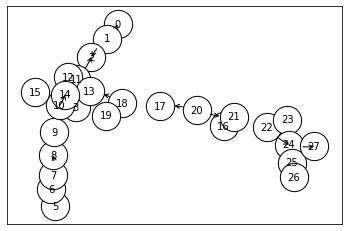

In [27]:
explanation.visualize_graph()

In [28]:
explanation.node_mask

tensor([[0.0842],
        [0.0781],
        [0.0829],
        [0.0765],
        [0.0000],
        [0.0864],
        [0.0920],
        [0.0849],
        [0.0937],
        [0.0782],
        [0.0853],
        [0.0768],
        [0.0876],
        [0.1143],
        [0.0780],
        [0.0822],
        [0.0913],
        [0.0785],
        [0.0934],
        [0.0893],
        [0.0869],
        [0.0939],
        [0.1005],
        [0.0912],
        [0.0853],
        [0.0745],
        [0.0775],
        [0.0822],
        [0.0000]], device='cuda:2')

In [32]:
explanation.edge_mask

tensor([0.9721, 0.0388, 0.0388, 0.9724, 0.0000, 0.9722, 0.0396, 0.0000, 0.0396,
        0.0000, 0.0000, 0.0000, 0.0387, 0.0000, 0.0000, 0.0396, 0.0377, 0.0397,
        0.9721, 0.0394, 0.0000, 0.0385, 0.0393, 0.0396, 0.0377, 0.0407, 0.0396,
        0.0400, 0.0341, 0.0370, 0.0548, 0.0397, 0.0383, 0.9724, 0.0417, 0.0000,
        0.9725, 0.0399, 0.0000, 0.0000, 0.0394, 0.0394, 0.0000, 0.0396, 0.9715,
        0.0396, 0.0385, 0.0432, 0.0391, 0.0387, 0.0396, 0.9727, 0.0342, 0.0392,
        0.0302, 0.0397, 0.0389, 0.9719, 0.0379, 0.0382, 0.0000, 0.0394, 0.0363,
        0.0377, 0.9722, 0.0000], device='cuda:2')

In [22]:
# deprecated

'''
explainer = GNNExplainer(model, lr=1e-4, epochs=300, return_type='regression')

x = data.x
edge_index = data.edge_index
y = data.y
batch_drug = data.batch
edge_features = data.edge_features
x_cell_mut = data.target

# model_args = (
#     x_cell_mut,
#     batch_drug,
#     edge_features
# )

kwargs = {
    "x_cell_mut": x_cell_mut,
    "batch_drug": batch_drug,
    "edge_feat": edge_features
}

node_feature_mask, edge_mask = explainer.explain_graph(x = x, edge_index = edge_index, x_cell_mut = x_cell_mut, edge_feat = edge_features)
# node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, **kwargs)
'''


Explain graph:   0%|                                                                                                                                                              | 0/300 [00:00<?, ?it/s]

debug h torch.Size([37, 334])
debug edge torch.Size([2, 82])
36 82
36 119


AssertionError: 

In [23]:
edge_features[edge_features==0].shape

torch.Size([36])

In [24]:
x.shape

torch.Size([37, 334])

In [25]:
edge_index.size(1)

82

In [ ]:
# debug rgcn model
(N, F) = x.size()
std = 0.1
node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)
node_feat_mask

In [ ]:
h = x * node_feat_mask.sigmoid().cuda()
h

In [ ]:
h.shape

- node_feature_mask: size = node feature length (334/...), importance of each node feature (invariant of atoms)
- edge_mask: size = edge number, importance of edges, stored in the sequence of edge_index (0,1),(0,5),(1,...

In [ ]:
one.edge_index

In [ ]:
edge_mask

In [ ]:
node_feature_mask

In [ ]:
edge_mask_cpu = edge_mask.to('cpu')
edge_index_cpu = edge_index.to('cpu')

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx=None, edge_index=edge_index_cpu, edge_mask=edge_mask_cpu)
plt.show()

In [ ]:
G[0]

In [ ]:
G[5][0]

In [ ]:
explainer = GNNExplainer(model, lr=1e-4, epochs=300)

for data in test_loader:
    x = data.x
    edge_index = data.edge_index
    y = data.y
    batch = data.batch
    edge_features = data.edge_features
    target = data.target
    
    node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, batch=batch, edge_feat = edge_features)
    ax, G = explainer.visualize_subgraph(edge_index, edge_mask, y=y)